In [1]:
!export LD_LIBRARY_PATH=/opt/conda/lib
!export XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir
!export PATH=/usr/local/cuda-11.7/bin:${PATH}

In [ ]:
# import the libraries

import logging
import warnings
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib
import random
from tqdm import tqdm
import pandas as pd

import h5py
import os
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape,Conv1D,Flatten,Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass
from sklearn.utils import shuffle
AUTOTUNE = tf.data.AUTOTUNE
from sklearn.preprocessing import StandardScaler
import tqdm
import gc

os.environ['PATH']=os.environ['PATH']+':/usr/local/cuda/bin'
os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/home/jarugula/cuda_data_dir'

In [3]:
# define your plot style

best_style = {
    "font.family": "sans-serif",
    "mathtext.fontset": "custom",
    "mathtext.rm": "TeX Gyre Heros",
    "mathtext.bf": "TeX Gyre Heros:bold",
    "mathtext.sf": "TeX Gyre Heros",
    "mathtext.it": "TeX Gyre Heros:italic",
    "mathtext.tt": "TeX Gyre Heros",
    "mathtext.cal": "TeX Gyre Heros",
    "mathtext.default": "regular",
    "figure.figsize": (10.0, 10.0),
    "font.size": 26,
    "axes.labelsize": "medium",
    "axes.unicode_minus": False,
    "xtick.labelsize": "small",
    "ytick.labelsize": "small",
    "legend.fontsize": "small",
    "legend.handlelength": 1.5,
    "legend.borderpad": 0.5,
    "xtick.direction": "in",
    "xtick.major.size": 12,
    "xtick.minor.size": 6,
    "xtick.major.pad": 6,
    "xtick.top": True,
    "xtick.major.top": True,
    "xtick.major.bottom": True,
    "xtick.minor.top": True,
    "xtick.minor.bottom": True,
    "xtick.minor.visible": True,
    "ytick.direction": "in",
    "ytick.major.size": 12,
    "ytick.minor.size": 6.0,
    "ytick.right": True,
    "ytick.major.left": True,
    "ytick.major.right": True,
    "ytick.minor.left": True,
    "ytick.minor.right": True,
    "ytick.minor.visible": True,
    "grid.alpha": 0.8,
    "grid.linestyle": ":",
    "axes.linewidth": 2,
    "savefig.transparent": False,
}
plt.style.use(best_style)
cols = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1", "#7a21dd"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cols)

In [4]:
# Trained Models with three different weight initializations

model_name1 = 'working_model_1M-2-034_seed38_v2.keras'
model_name2 = 'working_model_1M-2-034_seed128_v2.keras'
model_name3 = 'working_model_1M-2-034_seed1024_v2.keras'

### Data import and pre-processing

In [5]:
# Read the training and test data

data_path = '/deepskieslab/stronglensing/hsbi/datasets/'
image_dir = 'w0_8param_fixzv_train_1M'
column_name = "w0-g" # dark energy equation-of-state parameter

In [6]:
# Read the images and the corresponding metadata

if os.path.isdir(data_path+image_dir):
    images = np.load(data_path+image_dir+'/CONFIGURATION_1_images.npy', allow_pickle=True)
    metadata = pd.read_csv(data_path+image_dir+'/CONFIGURATION_1_metadata.csv')
else:
   print("Data not found")

In [7]:
images = np.einsum('lkij->lijk',images)
theta = metadata[column_name].to_numpy()

In [8]:
# normalize image each image by the sum of all pixels, make it such that the sum of all pixels is 1024 (32 X32)
images = 1024*(images/np.sum(images, axis=(1,2), keepdims=True))

# manually standardies pixels across all images. 
# In this analysis we do not standerdize the images and parameter. Hence we use mean=0 and std=1.0

images = images.reshape(images.shape[0], -1)
# means_image = np.mean(images, axis=0)
# std_image = np.std(images, axis=0)
means_image = 0.0
std_image = 1.0
images = (images - means_image) / std_image
images = images.reshape(images.shape[0], 32, 32, 1)


#manually standardize the theta (w)
mean_theta = 0.0 
std_theta = 1.0 
theta = (theta - mean_theta)/std_theta

### Split the data into train and test

In [9]:
x_train , x_test, theta_train, theta_test, y_train, y_test = train_test_split(images, theta, np.ones_like(theta), test_size=0.2, random_state=0)
true_test_theta = np.copy(theta_test)
true_test_theta = true_test_theta*std_theta + mean_theta

del images, theta
gc.collect()

53

### Load the saved trained models 

In [ ]:
# load models with different seeds
model1 = tf.keras.models.load_model(model_name1)
model2 = tf.keras.models.load_model(model_name2)
model3 = tf.keras.models.load_model(model_name3)

### Pre-processing of the test data

In [11]:
# for the test set create shuffled dataset
y_test_noshuffle = np.ones(len(theta_test))

# take a copy of image and theta dataset and shuffle just the theta values
images_shuffle = np.copy(x_test)
theta_test_shuffle = np.copy(theta_test)
theta_test_shuffle = shuffle(theta_test_shuffle, random_state=0)
y_test_shuffle = np.zeros(len(theta_test_shuffle))

x_test_concat = np.concatenate((x_test, images_shuffle), axis=0)
theta_test_concat = np.concatenate((theta_test, theta_test_shuffle), axis=0)
y_test_concat = np.concatenate((y_test_noshuffle, y_test_shuffle), axis=0)

### Plot the Receiver Operating Curve (ROC) 

In [12]:
# make predictions
def roc_auc(x_test_concat, theta_test_concat, model):
    '''
    Inputs:
    x_test_concat: List of strong lens images 
    theta_test_concat: List of thetas both shuffled and unshuffled
    model: The model for testing

    Returns:
    fpr: False positive Rate
    tpr: true Positive Rate
    thresholds: to calculate fpr and tpr
    roc_auc: The AUC score
    '''
    y_pred = model.predict([x_test_concat, theta_test_concat])
    y_pred_prob = tf.nn.sigmoid(y_pred) # probability that sample is from p(x,theta)
    fpr, tpr, thresholds = roc_curve(y_test_concat, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

def save_roc_auc(fpr, tpr, thresholds, roc_auc, model_name, seed):
    np.savez('aucroc_seed'+seed+'.npy', fpr=fpr, tpr=tpr, thresholds=thresholds, roc_auc=roc_auc)
    return 

In [13]:
fpr1, tpr1, thresholds1, roc_auc1 = roc_auc(x_test_concat, theta_test_concat, model1)
fpr2, tpr2, thresholds2, roc_auc2 = roc_auc(x_test_concat, theta_test_concat, model2)
fpr3, tpr3, thresholds3, roc_auc3 = roc_auc(x_test_concat, theta_test_concat, model3)

In [14]:
# # Save the roc outputs to a file
# _ = save_roc_auc(fpr1, tpr1, thresholds1, roc_auc1, model_name1, '38')
# _ = save_roc_auc(fpr2, tpr2, thresholds2, roc_auc2, model_name2, '128')
# _ = save_roc_auc(fpr3, tpr3, thresholds3, roc_auc3, model_name3, '1024')

In [20]:
# # Function to read the saved roc outputs
# def read_roc_file(filename):
#     npy = np.load(filename)
#     fpr = npy["fpr"]
#     tpr = npy["tpr"]
#     thresholds = npy["thresholds"]
#     roc_auc = npy["roc_auc"]
#     return fpr, tpr, thresholds, roc_auc

In [21]:
# # Read the saved outputs of the roc
# roc_name1 = "aucroc_seed42.npz"
# roc_name2 = "aucroc_seed82.npz"
# roc_name3 = "aucroc_seed124.npz"
# fpr1, tpr1, thresholds1, roc_auc1 = read_roc_file(roc_name1)
# fpr2, tpr2, thresholds2, roc_auc2 = read_roc_file(roc_name2)
# fpr3, tpr3, thresholds3, roc_auc3 = read_roc_file(roc_name3)
# fpr4, tpr4, thresholds4, roc_auc4 = read_roc_file(roc_name4)

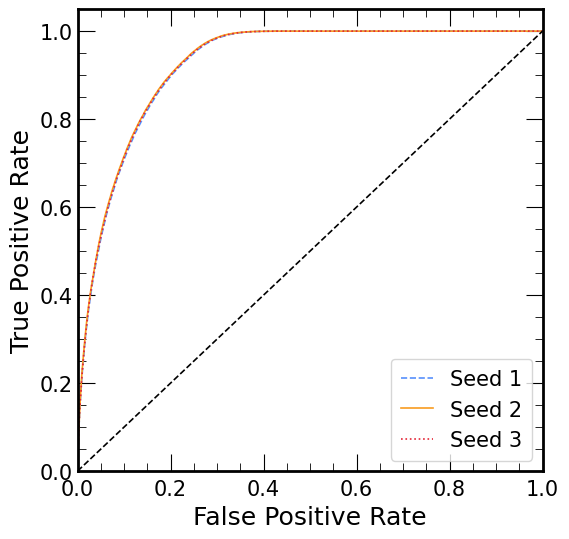

In [36]:
plt.figure(figsize=(6, 6))
lw = 1.2
plt.plot(fpr1, tpr1, lw=lw, label='Seed 1', ls='--')
plt.plot(fpr2, tpr2, lw=lw, label='Seed 2', ls='-')
plt.plot(fpr3, tpr3, lw=lw, label='Seed 3', ls=':')

plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# plt.text(0.7, 0.05, 'AUC = {}'.format(np.round(roc_auc, 2)), fontsize = 16, 
#          bbox = dict(facecolor = 'grey', alpha = 0.2))

plt.tick_params(axis='both', which='both', labelsize='xx-small')
plt.xlabel('False Positive Rate', fontsize='x-small')
plt.ylabel('True Positive Rate', fontsize='x-small')
plt.legend(fontsize='xx-small')
plt.savefig('roc_auc_random_seeds.pdf')
# plt.title('Receiver operating characteristic example')
plt.show()

### Calculate the Analytical Posterior 

The analytical equation to calculate the posterior is given by

\begin{equation}
\begin{split}
    p(w|\{x\}) &= \frac{p(w)~\prod_{i}r(x_i|w)}{\int dw^{\prime}~ p(w^{\prime})~\prod_{i}r(x_{i}|w^{\prime})},\\
        &= p(w)~\left( \int dw^{\prime}~p(w^{\prime})~\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)} \right)^{-1}.
\end{split}
\end{equation}

```likelihood_diff``` function calculates $log\ r(x|w^{\prime}) - log\ r(x|w)$  for one image $x$ 

This is same as calculating $\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_likelihood``` function calculates  $\sum_{i} log\ r(x_{i}|w^{\prime}) - log\ r(x_{i}|w)$ for a population of strong lens images $\{x_{i}\}$

This is same as calculating $\prod_{i}\frac{r(x_i|w^{\prime})}{r(x_i|w)}$ in the posterior equation

```get_joint_posterior``` calculates the sum of posterior for all the theta ($w$) values and gives the inverse of the sum as shown in the equation

In [ ]:
import numba as nb

@nb.jit
def get_logr_distribution(model, images, sample_theta):
    '''
    Function to predict the log likelihood-to-evidence ratio (logr) of the test data

    Input:
    model: The trained model 
    images: test images
    sample_theta: a list of theta values to compute logr for
    '''
    output_probs = []
    for image in images:
        test_image_array = np.concatenate([image[np.newaxis, :]]*len(sample_theta), axis=0)
        output = model.predict([test_image_array, sample_theta], verbose=0).flatten()
        output_probs.append(output)
    return np.array(output_probs)

class Posterior:
    def __init__(self, lnr, thetas):
        self.lnr = lnr
        self.thetas = thetas

    def likelihood_diff(self, image_index):
        # exp_diff_lnr = np.empty((len(self.thetas), len(self.thetas)))
        diff_lnr_list = np.empty((len(self.thetas), len(self.thetas)))
        for i in range(len(self.thetas)):
            diff_lnr = self.lnr[image_index, i] - self.lnr[image_index]
            # exp_diff_lnr[i] = np.exp(diff_lnr)
            diff_lnr_list[i] = diff_lnr
        # return exp_diff_lnr
        return diff_lnr_list

    def get_joint_likelihood(self, n_images):
        likelihood = np.empty((n_images, len(self.thetas), len(self.thetas)))
        for i in range(n_images):
            likelihood[i] = self.likelihood_diff(i)
        # joint_likelihood = np.prod(likelihood, axis=0)
        joint_likelihood = np.sum(likelihood, axis=0)
        joint_likelihood = np.exp(joint_likelihood)
        return joint_likelihood
    
    def get_joint_posterior(self, n_images):
        joint_likelihood = self.get_joint_likelihood(n_images)
        joint_posterior = 1. / np.sum(joint_likelihood, axis=0)
        return joint_posterior
    
def get_joint_posterior_probability(lnr, thetas, n_images):
    '''
    Function to sample from the posterior probability distribution.

    Output:
    The posterior probability, mean and standard deviation
    '''
    posterior = Posterior(lnr, thetas)
    joint_posterior = posterior.get_joint_posterior(n_images)
    sampled_values = np.random.choice(thetas, size=1000, p=joint_posterior)
    weighted_mean = np.mean(sampled_values)
    weighted_std_dev = np.std(sampled_values)
    # weighted_mean = np.sum(thetas * joint_posterior) / np.sum(joint_posterior)
    # weighted_std_dev = np.sqrt(np.sum(joint_posterior * (thetas - weighted_mean)**2) / np.sum(joint_posterior))
    return joint_posterior, weighted_mean, weighted_std_dev


In [61]:
# select the images where theta is between -1.5, -0.5
x_test_copy = np.copy(x_test[0:100])
inx = np.where((true_test_theta[0:100] > -1.5) & (true_test_theta[0:100] < -0.5))
x_test_copy = x_test_copy[inx]
theta_test_copy = true_test_theta[0:100][inx]

# select 20 images
x_test_copy = x_test_copy[0:20]
theta_test_copy = theta_test_copy[0:20]

In [70]:
sample_theta_unstd = np.linspace(-2.5, -0.15, 1000)

sample_theta = (sample_theta_unstd - mean_theta)/std_theta
x_test_lnr_20_model1 = get_logr_distribution(model1, x_test_copy, sample_theta)
x_test_lnr_20_model2 = get_logr_distribution(model2, x_test_copy, sample_theta)
x_test_lnr_20_model3 = get_logr_distribution(model3, x_test_copy, sample_theta)

In [72]:
def get_posterior_samples(lnr, thetas, n_images):
    '''
    Function to calculate the analytical posterior from individual strong lens image

    Outputs:
    Posterior probability distribution
    Samples, mean, and std obtained by sampling from the posterior
    '''
    posteriors_all_list = []
    posterior_all_samples = []
    for i in range(n_images):
        posterior, posterior_mean, posterior_std = get_joint_posterior_probability(lnr[i:i+1], thetas, 1)
        posteriors_all_list.append((posterior_mean, posterior_std))
        posterior_all_samples.append(posterior)
    posteriors_all = np.vstack(posteriors_all_list)
    posterior_all_samples = np.array(posterior_all_samples)
    return posteriors_all, posterior_all_samples

In [73]:
# calculate the analytical posterior for 20 strong lenses 
posteriors_all1, posterior_all_samples1 = get_posterior_samples(x_test_lnr_20_model1, sample_theta, 20)
posteriors_all2, posterior_all_samples2 = get_posterior_samples(x_test_lnr_20_model2, sample_theta, 20)
posteriors_all3, posterior_all_samples3 = get_posterior_samples(x_test_lnr_20_model3, sample_theta, 20)

### Plot the analytical posteriors for random test images for the three models

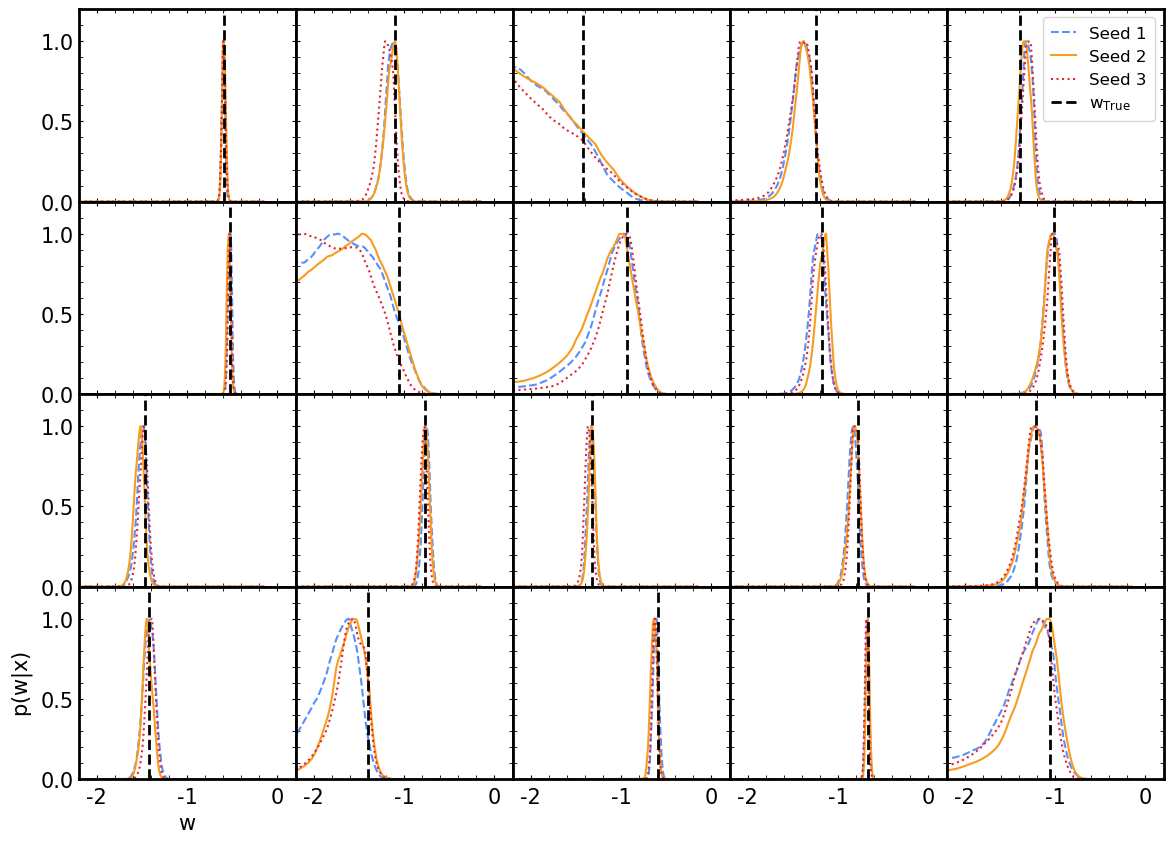

In [108]:
num_rows= 4
num_cols = 5
hspace = 0.00
wspace = 0.00
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10), sharex=True, sharey=True)
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        axes[i, j].plot(sample_theta_unstd, posterior_all_samples1[index]/np.max(posterior_all_samples1[index]), ls='--', label='Seed 1') 
        axes[i, j].plot(sample_theta_unstd, posterior_all_samples2[index]/np.max(posterior_all_samples2[index]), ls='-', label='Seed 2')
        axes[i, j].plot(sample_theta_unstd, posterior_all_samples3[index]/np.max(posterior_all_samples3[index]), ls=':', label='Seed 3')
        axes[i, j].axvline(theta_test_copy[index], color='k', ls='--', linewidth=2, label=r'$\rm w_{True}$')
        axes[i, j].set_ylim([0.0, 1.2])
        axes[i, j].set_xlim([-2.2, 0.2])
        axes[i, j].tick_params(axis='both', which='both', labelsize='xx-small', length=3)
        axes[i, j].xaxis.set_major_locator(MultipleLocator(1.0))
        axes[i, j].xaxis.set_major_formatter('{x:.0f}')

axes[0, 4].legend(fontsize='12', loc='upper right')
axes[3, 0].set_xlabel(r'$w$', fontsize='xx-small')
axes[3, 0].set_ylabel(r'$p(w | x)$', fontsize='xx-small')
plt.subplots_adjust(hspace=hspace, wspace=wspace)
# plt.tight_layout()
plt.savefig('posterior_seeds.pdf')
